<a href="https://colab.research.google.com/github/StratagemGIS/notebooks/blob/main/projects/30_DIY_Google_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
%%capture
!pip install pyogrio momepy contextily

In [2]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import networkx as nx
import pandas as pd
import pooch
from shapely.geometry import LineString, Point

# Datasets

## Download and Read

In [3]:
aoi_file = pooch.retrieve(
    'https://github.com/StratagemGIS/datasets/raw/main/vector/City_Boundary.zip',
    known_hash='431710489ce01850be3ed0ac816305b41cbd871b14fae7d3c94bb8da469c6aa6'
)

anb_file = pooch.retrieve(
    'https://github.com/StratagemGIS/datasets/raw/main/vector/geonb_anb_shp.zip',
    known_hash='67de38f5edb30f2578aef2a64f10a0a7cc7a8a1b77d680e34936574e35528f26'
)

nbrn_file = pooch.retrieve(
    'https://github.com/StratagemGIS/datasets/raw/main/vector/geonb_nbrn-rrnb_shp.zip',
    known_hash='90d36a48b0a53c6320890d1a3bcaee9f9b98d6ad734f910ac6998b01d974b5d5'
)

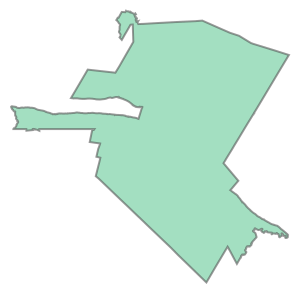

In [4]:
aoi = (
    gpd.read_file(aoi_file)
       .to_crs('EPSG:2953')
       .geometry
       .values[0]
)

aoi

In [5]:
nbrn = gpd.read_file(
    f'{nbrn_file}!geonb_nbrn-rrnb_road-route.shp',
    engine='pyogrio',
    bbox=aoi,
)

print(nbrn.shape)
nbrn.head()

(4269, 38)


,NID,ROADSEGID,STREETNAME,ST_TYPE,TYPE_POSI,PREFIX,SUFFIX,NBRLANES,RTENAME1EN,RTENAME2EN,...,L_HNUMSTR,R_HNUMSTR,L_HNUMF,L_HNUML,R_HNUMF,R_HNUML,PLACE_NAME,COUNTY,TRAV_DIR,geometry
0,80274C80616D472E81ED5538386CEAAF,9857341,MOORE Street,Street,S,None,None,2,None,None,...,Mixed,Mixed,216,213,148,155,Fredericton,Sunbury,None,"LINESTRING (2493506.194 7433962.622, 2493498.5..."
1,C69AB64F5A4A4AB7BEE6846ADA616139,11008592,FLAGSTONE Street,Street,S,None,None,2,None,None,...,Odd,Even,1,7,2,8,Hanwell,York,None,"LINESTRING (2479574.000 7432398.000, 2479592.0..."
2,CBF2FA425FC84C229C2B7377BAA4776D,11008603,STAIRS Lane,Lane,S,None,None,1,None,None,...,Even,Odd,514,516,515,517,New Maryland,York,None,"LINESTRING (2486078.258 7430043.413, 2486028.3..."
3,EB9385C9A7EE4095B5C90171BAD3D1B2,11008604,O'BRIEN Lane,Lane,S,None,None,1,None,None,...,Odd,Even,49,51,50,52,New Maryland,York,None,"LINESTRING (2485507.818 7432004.276, 2485526.7..."
4,7B22D7AAD836499E8AAE8E0F83022056,11008615,STARLING Crescent,Crescent,S,None,None,2,None,None,...,Odd,Even,1,27,2,28,Hanwell,York,None,"LINESTRING (2479899.878 7431528.262, 2479897.0..."


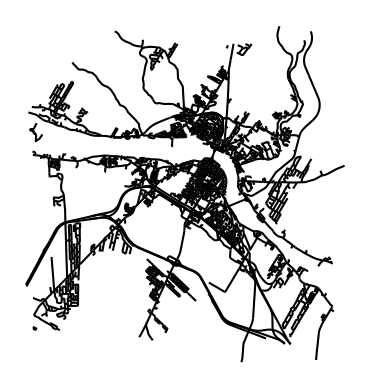

In [6]:
nbrn.geometry.plot(color='black')
plt.axis('off');

In [7]:
anb = gpd.read_file(
    f'{anb_file}!geonb_anb_addresses.shp',
    engine='pyogrio',
    bbox=aoi,
)
print(anb.shape)
anb.head()

(29845, 29)


,CIV_ID,ADDR_SYM,ADDR_DESC,CIVIC_NUM,NUM_SUFFIX,PID,STREET,ST_TYPE_E,ST_TYPE_F,RD_SIDE_E,...,STRUCT_F,STRU_NAME,ALT_ACCESS,COLL_MTHD,CREATED,MODIFIED,LATITUDE,LONGITUDE,SUB_COUNT,geometry
0,{774CF90A-D0E3-42FD-8722-3D2175EB7820},40 AV Katie AV,40 Avenue Katie Avenue,40,None,00000000,KATIE,Avenue,Avenue,RIGHT,...,Résidence,None,None,None,2001/08/23,2018-12-05,46.000071,-66.767511,None,POINT (2479279.192 7444469.235)
1,{3DD2093D-4AA0-4FE5-953D-483A54A5C43D},130 PR Rolling Hill DR,130 Promenade Rolling Hill Drive,130,None,75381608,ROLLING HILL,Drive,Promenade,RIGHT,...,Résidence,None,None,None,2001/08/29,2018-12-05,45.944531,-66.591039,None,POINT (2492941.200 7438265.450)
2,{6983EC9A-8C17-4D9F-96DF-4B5E8559CAE5},208 AL Serenity LN,208 Allée Serenity Lane,208,None,01499649,SERENITY,Lane,Allée,LEFT,...,Résidence,None,None,None,2001/09/17,2018-12-05,45.947560,-66.700130,None,POINT (2484483.650 7438617.700)
3,{5E53EFDD-6AAC-4D38-9C8A-918E1F47BE0A},50 PR Bliss Carman DR,50 Promenade Bliss Carman Drive,50,None,75382036,BLISS CARMAN,Drive,Promenade,LEFT,...,Résidence,None,None,None,2001/09/20,2018-12-05,45.937620,-66.644492,None,POINT (2488795.350 7437503.550)
4,{407928BD-FBB3-4C87-B380-4D96120F1570},66 PR Bliss Carman DR,66 Promenade Bliss Carman Drive,66,None,75382028,BLISS CARMAN,Drive,Promenade,LEFT,...,Résidence,None,None,None,2001/09/20,2018-12-05,45.937793,-66.643984,None,POINT (2488834.750 7437522.700)


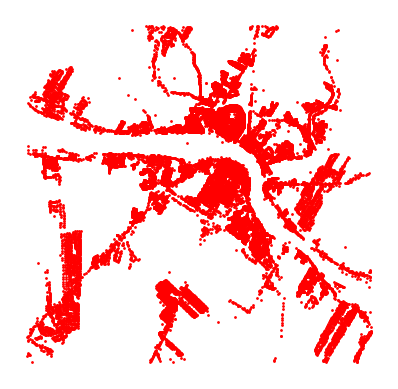

In [8]:
anb.geometry.plot(markersize=1, color='red')
plt.axis('off');

## Pre-Processing

In [9]:
def tweak_nbrn(df):

    return (df
      .assign(street_name=lambda df_: df_.STREETNAME.str.title(),
              street_type=lambda df_: df_.ST_TYPE.astype('category'),
              paved_status=lambda df_: df_.PAVSTATUS.astype('category'),
              traffic_direction=lambda df_: df_.TRAFFICDIR.astype('category'),
              county=lambda df_: df_.COUNTY.astype('category')
              )
      [['street_name', 'street_type', 'paved_status', 'traffic_direction',
        'county', 'geometry']]
      .reset_index(drop=True)
    )

nbrn_cleaned = tweak_nbrn(nbrn)
print(nbrn_cleaned.shape)
nbrn_cleaned.head()

(4269, 6)


,street_name,street_type,paved_status,traffic_direction,county,geometry
0,Moore Street,Street,Paved,Both Directions,Sunbury,"LINESTRING (2493506.194 7433962.622, 2493498.5..."
1,Flagstone Street,Street,Paved,Both Directions,York,"LINESTRING (2479574.000 7432398.000, 2479592.0..."
2,Stairs Lane,Lane,Unpaved,Both Directions,York,"LINESTRING (2486078.258 7430043.413, 2486028.3..."
3,O'Brien Lane,Lane,Unpaved,Both Directions,York,"LINESTRING (2485507.818 7432004.276, 2485526.7..."
4,Starling Crescent,Crescent,Paved,Both Directions,York,"LINESTRING (2479899.878 7431528.262, 2479897.0..."


In [10]:
def tweak_anb(df):
    return (df
      .assign(CIVIC_NUM=lambda df_: df_.CIVIC_NUM.astype(str),
              address=lambda df_: (df_.CIVIC_NUM + ' ' + df_.STREET + ' ' + df_.ST_TYPE_E))
      .assign(address=lambda df_: df_.address.str.title())
      [['address', 'geometry']]
      .drop_duplicates(subset=['address'])
      .reset_index(drop=True)
    )


anb_cleaned = tweak_anb(anb)
print(anb_cleaned.shape)
anb_cleaned.head()

(29565, 2)


,address,geometry
0,40 Katie Avenue,POINT (2479279.192 7444469.235)
1,130 Rolling Hill Drive,POINT (2492941.200 7438265.450)
2,208 Serenity Lane,POINT (2484483.650 7438617.700)
3,50 Bliss Carman Drive,POINT (2488795.350 7437503.550)
4,66 Bliss Carman Drive,POINT (2488834.750 7437522.700)


# Network Dataset

In [11]:
G = momepy.gdf_to_nx(nbrn_cleaned, directed=False, approach='primal')

In [12]:
nodes_df = gpd.GeoSeries(list(map(Point, G.nodes)), crs='EPSG:2953')
nearest_geom_indices = nodes_df.sindex.nearest(anb_cleaned.geometry)
anb_cleaned['node'] = nodes_df.iloc[nearest_geom_indices[1]].values

anb_cleaned.head()

,address,geometry,node
0,40 Katie Avenue,POINT (2479279.192 7444469.235),POINT (2479306.000 7444533.000)
1,130 Rolling Hill Drive,POINT (2492941.200 7438265.450),POINT (2492916.264 7438112.726)
2,208 Serenity Lane,POINT (2484483.650 7438617.700),POINT (2484464.926 7438480.877)
3,50 Bliss Carman Drive,POINT (2488795.350 7437503.550),POINT (2488707.823 7437446.218)
4,66 Bliss Carman Drive,POINT (2488834.750 7437522.700),POINT (2488967.836 7437576.340)


# API Function

In [13]:
def plot_route(from_address, to_address):

    def get_node_as_pt(address):
        return anb_cleaned.query('address == @address').node.values[0].coords[:][0]

    def get_geom_as_pt(address):
        return anb_cleaned.query('address == @address').geometry.values[0].coords[:][0]

    # Get the coordinates for from and to
    start_pt = get_geom_as_pt(from_address)
    end_pt = get_geom_as_pt(to_address)

    # Get the path for from and to based on it's node
    start_node = get_node_as_pt(from_address)
    end_node = get_node_as_pt(to_address)
    path = LineString(nx.shortest_path(G, start_node, end_node))

    # Plot the path
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(*path.xy, color='red', label='Path')
    ax.plot(*start_pt, 'go', label=from_address)
    ax.plot(*end_pt, 'bo', label=to_address)

    # Add basemap
    cx.add_basemap(
        ax,
        zoom=17,
        crs='EPSG:2953',
        source=cx.providers.OpenStreetMap.Mapnik,
        attribution=False
    )

    plt.legend()
    plt.axis('off')

# Results

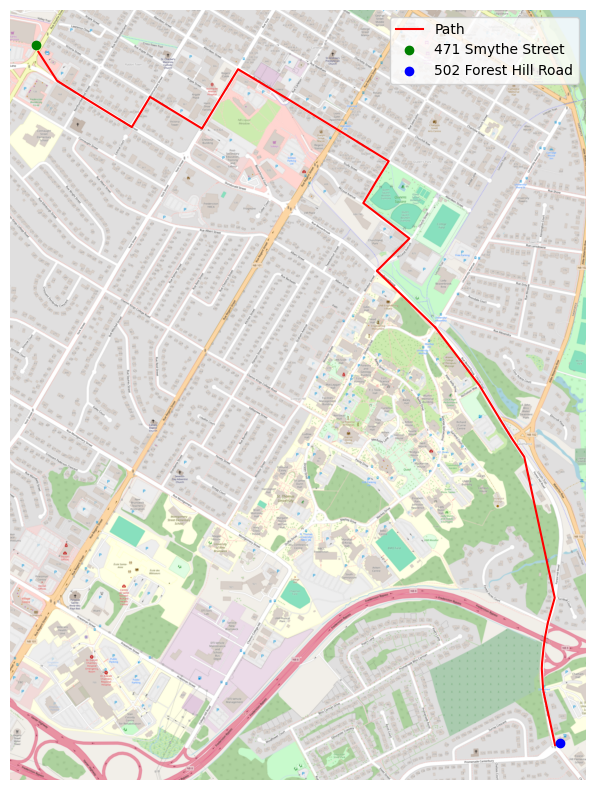

In [14]:
plot_route(
    from_address='471 Smythe Street',    # Atlantic Super Store
    to_address='502 Forest Hill Road',   # Tokyo Ramen
)

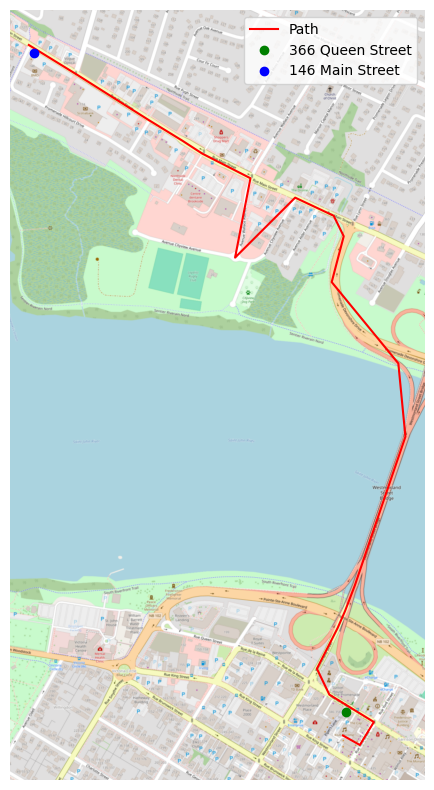

In [15]:
plot_route(
    from_address='366 Queen Street',     # J's Asian Kitchen (Downtown)
    to_address='146 Main Street',        # J's Asian Kitchen (Northside)
)

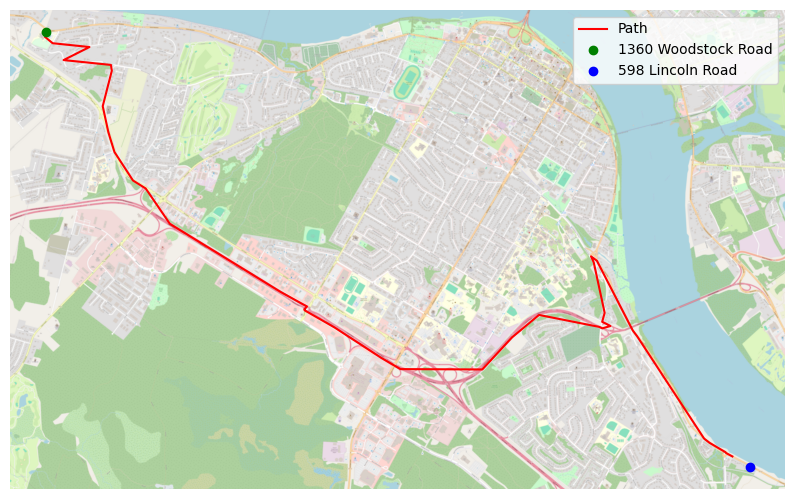

In [16]:
plot_route(
    from_address='1360 Woodstock Road',  # Garden Creek School
    to_address='598 Lincoln Road',       # Plant Propagation Centre
)